Ref: https://levelup.gitconnected.com/building-seq2seq-lstm-with-luong-attention-in-keras-for-time-series-forecasting-1ee00958decb

In [316]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Import data

In [317]:
data = pd.read_csv('../data/num_file/min_10/p040.csv')

In [318]:
print(data)

                  datetime  count
0      2022-04-21 01:40:00    200
1      2022-04-21 01:50:00    833
2      2022-04-21 02:00:00     65
3      2022-04-21 02:10:00      0
4      2022-04-21 02:20:00      0
...                    ...    ...
19495  2022-09-03 10:50:00   4034
19496  2022-09-03 11:00:00   3556
19497  2022-09-03 11:10:00   1082
19498  2022-09-03 11:20:00   3937
19499  2022-09-03 11:30:00   4176

[19500 rows x 2 columns]


If there is no people, use NaN.

In [319]:
data.loc[data['count']==0, 'count'] = np.NaN

In [320]:
print(data)

                  datetime   count
0      2022-04-21 01:40:00   200.0
1      2022-04-21 01:50:00   833.0
2      2022-04-21 02:00:00    65.0
3      2022-04-21 02:10:00     NaN
4      2022-04-21 02:20:00     NaN
...                    ...     ...
19495  2022-09-03 10:50:00  4034.0
19496  2022-09-03 11:00:00  3556.0
19497  2022-09-03 11:10:00  1082.0
19498  2022-09-03 11:20:00  3937.0
19499  2022-09-03 11:30:00  4176.0

[19500 rows x 2 columns]


<Axes: >

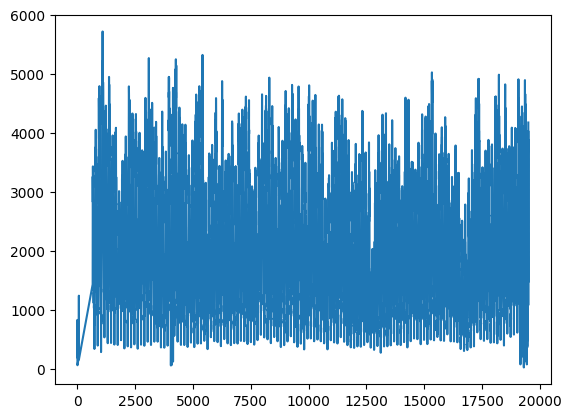

In [321]:
data['count'] = data['count'].interpolate(method='linear')
data['count'].plot()

## Normalize data

<Axes: >

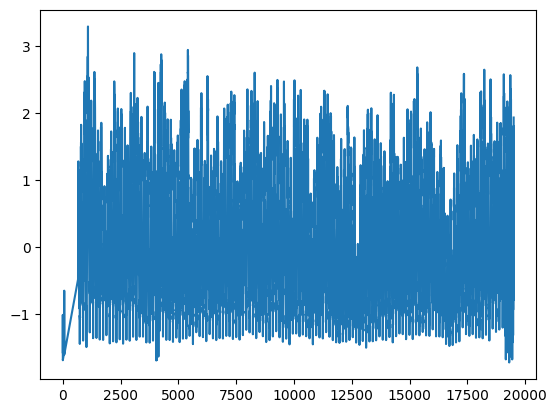

In [322]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
data['count'] = scaler.fit_transform(data[['count']])
data['count'].plot()

In [323]:
print(data)

                  datetime     count
0      2022-04-21 01:40:00 -1.563824
1      2022-04-21 01:50:00 -1.007215
2      2022-04-21 02:00:00 -1.682532
3      2022-04-21 02:10:00 -1.680572
4      2022-04-21 02:20:00 -1.678611
...                    ...       ...
19495  2022-09-03 10:50:00  1.807486
19496  2022-09-03 11:00:00  1.387171
19497  2022-09-03 11:10:00 -0.788265
19498  2022-09-03 11:20:00  1.722192
19499  2022-09-03 11:30:00  1.932349

[19500 rows x 2 columns]


In [324]:
encode_input_data = []
decode_input_data = []
decode_output_data = []
time_step = 6

for i in range(len(data)-time_step-1):
    encode_input_data.append(data['count'].values[i:i+time_step])
    decode_input_data.append(data['count'].values[i:i+time_step])
    decode_output_data.append(data['count'].values[i+1:i+time_step+1])

encode_input_data = np.array(encode_input_data)
decode_input_data = np.array(decode_input_data)
decode_output_data = np.array(decode_output_data)

In [325]:
encode_input_data = encode_input_data.reshape(encode_input_data.shape[0], encode_input_data.shape[1], 1)
decode_input_data = decode_input_data.reshape(decode_input_data.shape[0], decode_input_data.shape[1], 1)
decode_output_data = decode_output_data.reshape(decode_output_data.shape[0], decode_output_data.shape[1], 1)

In [326]:
train_size = int(len(encode_input_data)*0.8)
encode_input_data_train = encode_input_data[:train_size]
decode_input_data_train = decode_input_data[:train_size]
decode_output_data_train = decode_output_data[:train_size]
encode_input_data_test = encode_input_data[train_size:]
decode_input_data_test = decode_input_data[train_size:]
decode_output_data_test = decode_output_data[train_size:]

## Model

In [327]:
from keras.layers import Input, LSTM, BatchNormalization, RepeatVector, TimeDistributed, Dense, dot, multiply, concatenate, Activation
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

In [328]:
input_train = Input(shape=(time_step, 1))
output_train = Input(shape=(time_step, 1))

In [329]:
# encoder_last_h1, encoder_last_h2, encoder_last_c = LSTM(32, activation='relu', return_sequences=False, return_state=True)(input_train)
encoder_last_h1, encoder_last_h2, encoder_last_c = LSTM(32, return_sequences=False, return_state=True)(input_train)

In [330]:
encoder_last_h1 = BatchNormalization()(encoder_last_h1)
encoder_last_c = BatchNormalization()(encoder_last_c)

In [331]:
decoder = RepeatVector(time_step)(encoder_last_h1)
# decoder = LSTM(32, activation='relu', return_state=False, return_sequences=True)(decoder, initial_state=[encoder_last_h1, encoder_last_c])
decoder = LSTM(32, return_state=False, return_sequences=True)(decoder, initial_state=[encoder_last_h1, encoder_last_c])

In [332]:
out = TimeDistributed(Dense(1))(decoder)

In [333]:
model = Model(inputs=input_train, outputs=out)
opt = Adam(learning_rate=0.01)
model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mae'])
model.summary()

Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_25 (InputLayer)          [(None, 6, 1)]       0           []                               
                                                                                                  
 lstm_24 (LSTM)                 [(None, 32),         4352        ['input_25[0][0]']               
                                 (None, 32),                                                      
                                 (None, 32)]                                                      
                                                                                                  
 batch_normalization_30 (BatchN  (None, 32)          128         ['lstm_24[0][0]']                
 ormalization)                                                                             

In [334]:
es = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')
history = model.fit(encode_input_data_train, decode_output_data_train, epochs=100, batch_size=128, validation_split=0.1, callbacks=[es], shuffle=False)

Epoch 1/100
110/110 [==============================] - 2s 9ms/step - loss: 0.2574 - mae: 0.3029 - val_loss: 0.0781 - val_mae: 0.2021
Epoch 2/100
110/110 [==============================] - 1s 5ms/step - loss: 0.1072 - mae: 0.2285 - val_loss: 0.1992 - val_mae: 0.3681
Epoch 3/100
110/110 [==============================] - 1s 5ms/step - loss: 0.1029 - mae: 0.2217 - val_loss: 0.0559 - val_mae: 0.1872
Epoch 4/100
110/110 [==============================] - 1s 5ms/step - loss: 0.0691 - mae: 0.1859 - val_loss: 0.0374 - val_mae: 0.1485
Epoch 5/100
110/110 [==============================] - 1s 5ms/step - loss: 0.0425 - mae: 0.1505 - val_loss: 0.0310 - val_mae: 0.1419
Epoch 6/100
110/110 [==============================] - 1s 5ms/step - loss: 0.0379 - mae: 0.1430 - val_loss: 0.0359 - val_mae: 0.1532
Epoch 7/100
110/110 [==============================] - 1s 5ms/step - loss: 0.0362 - mae: 0.1388 - val_loss: 0.0307 - val_mae: 0.1433
Epoch 8/100
110/110 [==============================] - 1s 6ms/step - 

In [335]:
# model.save('./params/p040_seq2seq.keras')

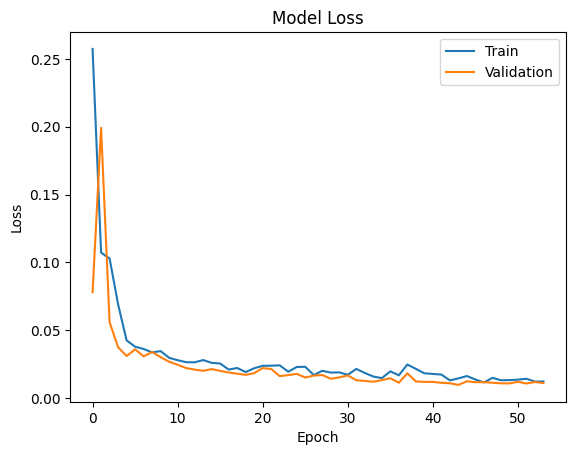

In [336]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()


In [337]:
predict_train = model.predict(encode_input_data_train)

488/488 [==============================] - 1s 2ms/step


In [338]:
predict_test = model.predict(encode_input_data_test)

122/122 [==============================] - 0s 1ms/step


In [339]:
print(predict_train.shape)

(15594, 6, 1)


In [340]:
print(predict_test.shape)

(3899, 6, 1)


In [341]:
predict = np.concatenate([predict_train, predict_test], axis=0)
print(predict.shape)

(19493, 6, 1)


In [342]:
print(predict_test[:, -1, :])

[[-0.33120853]
 [-0.30582654]
 [-0.4403966 ]
 ...
 [ 1.1886432 ]
 [ 1.2695472 ]
 [-0.31389385]]


In [343]:
print(decode_output_data_test[:, -1, :])

[[-0.38729511]
 [-0.41631265]
 [-0.55436576]
 ...
 [ 1.38717097]
 [-0.78826465]
 [ 1.72219157]]


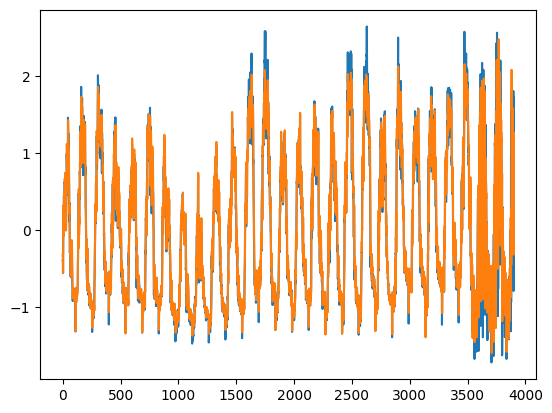

In [344]:
plt.plot(np.arange(decode_output_data_test.shape[0]), decode_output_data_test[:, -1, :])
plt.plot(np.arange(predict_test.shape[0]), predict_test[:, -1, :])
plt.show()

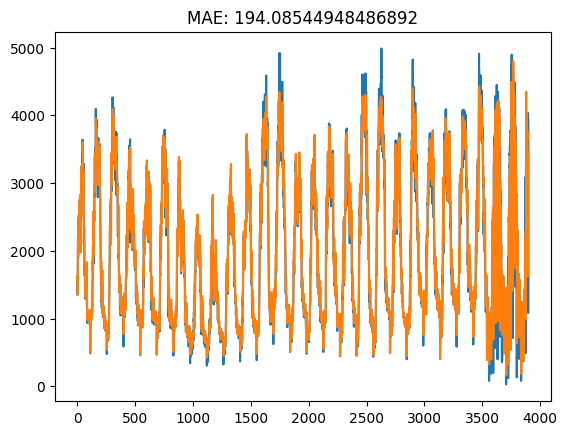

In [345]:
predict_test_data = scaler.inverse_transform(predict_test[:, -1, :])
decode_output_test_data = scaler.inverse_transform(decode_output_data_test[:, -1, :])
plt.plot(np.arange(decode_output_test_data.shape[0]), decode_output_test_data)
plt.plot(np.arange(predict_test_data.shape[0]), predict_test_data)
plt.title(f'MAE: {np.mean(np.abs((predict_test_data-decode_output_test_data)))}')
plt.show()

## Attention

In [346]:
input_train = Input(shape=(time_step, 1))
output_train = Input(shape=(time_step, 1))

In [347]:
# encoder_stack_h, encoder_last_h, encoder_last_c = LSTM(32, activation='relu', return_sequences=True, return_state=True)(input_train)
encoder_stack_h, encoder_last_h, encoder_last_c = LSTM(32, return_sequences=True, return_state=True)(input_train)
print(encoder_stack_h)
print(encoder_last_h)
print(encoder_last_c)

KerasTensor(type_spec=TensorSpec(shape=(None, 6, 32), dtype=tf.float32, name=None), name='lstm_26/PartitionedCall:1', description="created by layer 'lstm_26'")
KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='lstm_26/PartitionedCall:2', description="created by layer 'lstm_26'")
KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='lstm_26/PartitionedCall:3', description="created by layer 'lstm_26'")


In [348]:
encoder_last_h = BatchNormalization()(encoder_last_h)
encoder_last_c = BatchNormalization()(encoder_last_c)

In [349]:
decoder_input = RepeatVector(time_step)(encoder_last_h)
print(decoder_input)

KerasTensor(type_spec=TensorSpec(shape=(None, 6, 32), dtype=tf.float32, name=None), name='repeat_vector_13/Tile:0', description="created by layer 'repeat_vector_13'")


In [350]:
# decoder_stack_h = LSTM(32, activation='relu', return_sequences=True)(decoder_input, initial_state=[encoder_last_h, encoder_last_c])
decoder_stack_h = LSTM(32, return_sequences=True)(decoder_input, initial_state=[encoder_last_h, encoder_last_c])
print(decoder_stack_h)

KerasTensor(type_spec=TensorSpec(shape=(None, 6, 32), dtype=tf.float32, name=None), name='lstm_27/PartitionedCall:1', description="created by layer 'lstm_27'")


In [351]:
attention = dot([decoder_stack_h, encoder_stack_h], axes=[2, 2])

In [352]:
attention = Activation('softmax')(attention)

In [353]:
print(attention)

KerasTensor(type_spec=TensorSpec(shape=(None, 6, 6), dtype=tf.float32, name=None), name='activation_6/Softmax:0', description="created by layer 'activation_6'")


In [354]:
context = dot([attention, encoder_stack_h], axes=[2, 1])
context = BatchNormalization()(context)
print(context)

KerasTensor(type_spec=TensorSpec(shape=(None, 6, 32), dtype=tf.float32, name=None), name='batch_normalization_34/batchnorm/add_1:0', description="created by layer 'batch_normalization_34'")


In [355]:
decoder_combined_context = concatenate([context, decoder_stack_h])
print(decoder_combined_context)

KerasTensor(type_spec=TensorSpec(shape=(None, 6, 64), dtype=tf.float32, name=None), name='concatenate_6/concat:0', description="created by layer 'concatenate_6'")


In [356]:
out = TimeDistributed(Dense(1))(decoder_combined_context)
print(out)

KerasTensor(type_spec=TensorSpec(shape=(None, 6, 1), dtype=tf.float32, name=None), name='time_distributed_13/Reshape_1:0', description="created by layer 'time_distributed_13'")


In [357]:
model = Model(inputs=input_train, outputs=out)
opt = Adam(learning_rate=0.01, clipnorm=1.0)
model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mae'])
model.summary()

Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_27 (InputLayer)          [(None, 6, 1)]       0           []                               
                                                                                                  
 lstm_26 (LSTM)                 [(None, 6, 32),      4352        ['input_27[0][0]']               
                                 (None, 32),                                                      
                                 (None, 32)]                                                      
                                                                                                  
 batch_normalization_32 (BatchN  (None, 32)          128         ['lstm_26[0][1]']                
 ormalization)                                                                             

In [358]:
history = model.fit(encode_input_data_train, decode_output_data_train, epochs=100, batch_size=128, validation_split=0.1, callbacks=[es], shuffle=False)

Epoch 1/100
110/110 [==============================] - 3s 11ms/step - loss: 0.3090 - mae: 0.3772 - val_loss: 0.4419 - val_mae: 0.5544
Epoch 2/100
110/110 [==============================] - 1s 7ms/step - loss: 0.1404 - mae: 0.2714 - val_loss: 0.1981 - val_mae: 0.3500
Epoch 3/100
110/110 [==============================] - 1s 7ms/step - loss: 0.0675 - mae: 0.1905 - val_loss: 0.2136 - val_mae: 0.3677
Epoch 4/100
110/110 [==============================] - 1s 7ms/step - loss: 0.0595 - mae: 0.1819 - val_loss: 0.2277 - val_mae: 0.3866
Epoch 5/100
110/110 [==============================] - 1s 8ms/step - loss: 0.0537 - mae: 0.1775 - val_loss: 0.1737 - val_mae: 0.3320
Epoch 6/100
110/110 [==============================] - 1s 7ms/step - loss: 0.0465 - mae: 0.1627 - val_loss: 0.0956 - val_mae: 0.2536
Epoch 7/100
110/110 [==============================] - 1s 7ms/step - loss: 0.0461 - mae: 0.1620 - val_loss: 0.1441 - val_mae: 0.3194
Epoch 8/100
110/110 [==============================] - 1s 8ms/step -

In [359]:
# model.save('./params/p040_seq2seq_at.keras')

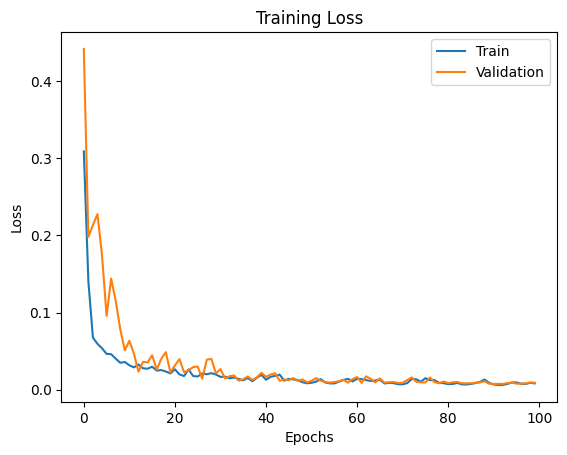

In [360]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])
plt.show()


In [361]:
predict_test = model.predict(encode_input_data_test)

122/122 [==============================] - 1s 2ms/step


In [362]:
predict_test_data = scaler.inverse_transform(predict_test[:, -1, :])

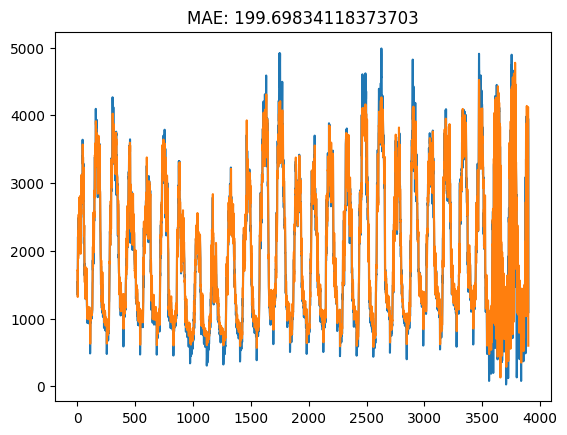

In [363]:
plt.plot(np.arange(decode_output_test_data.shape[0]), decode_output_test_data)
plt.plot(np.arange(predict_test_data.shape[0]), predict_test_data)
plt.title(f'MAE: {np.mean(np.abs((predict_test_data-decode_output_test_data)))}')
plt.show()

In [364]:
print(predict_test_data)

[[1712.7673 ]
 [1714.7074 ]
 [1487.2686 ]
 ...
 [4122.2803 ]
 [3118.6863 ]
 [ 599.21497]]


In [365]:
print(decode_output_test_data)

[[1538.]
 [1505.]
 [1348.]
 ...
 [3556.]
 [1082.]
 [3937.]]


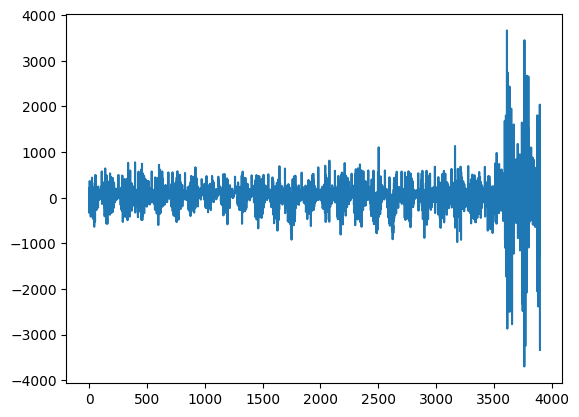

In [366]:
plt.plot(np.arange(decode_output_test_data.shape[0]), predict_test_data-decode_output_test_data)

In [367]:
from sklearn.metrics import mean_absolute_error

print(mean_absolute_error(decode_output_test_data, predict_test_data))

199.69834118373703
